# Import Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor,VotingRegressor

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [4]:
# Import data.
loan_data = pd.read_csv('loan_data_clean.csv', index_col = 0)
loan_data.drop(['issue_d'], axis = 1, inplace = True)

In [5]:
loan_data_defaults = loan_data[loan_data['loan_status'].isin(['Charged Off','Does not meet the credit policy. Status:Charged Off'])]
# Here we take only the accounts that were charged-off (written-off).

In [6]:
loan_data_defaults.shape

(41962, 48)

In [7]:
loan_data_defaults.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,revol_util,total_acc,total_rec_prncp,recoveries,mths_since_earliest_cr_line,mths_since_issue_d,good_bad,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_2,sub_grade_3,sub_grade_4,sub_grade_5,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
1,2500,2500,60,15.27,59.83,0,30000.0,Charged Off,1.00,3.0,0.0,9.4,4.0,456.46,117.08,224.0,72.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
8,5600,5600,60,21.28,152.39,4,40000.0,Charged Off,5.55,11.0,0.0,32.6,13.0,162.02,189.06,164.0,72.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
9,5375,5375,60,12.69,121.45,0,15000.0,Charged Off,18.08,2.0,0.0,36.5,3.0,673.48,269.29,159.0,72.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
12,9000,9000,36,13.49,305.38,0,30000.0,Charged Off,10.08,4.0,0.0,91.7,9.0,1256.14,444.30,164.0,72.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
14,10000,10000,36,10.65,325.74,3,100000.0,Charged Off,7.06,14.0,0.0,55.5,29.0,5433.47,645.10,319.0,72.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0


# Dependent Variables

Loss given default is calculated given the Outstanding debt-collection/Outstanding debt. In other words recoveries / outstanding debt. Hence we will calculated the recovery rate using the recoveries/funded amount as below. As a benchmark model, we will be using Generalized linear models. After which, we will explore using random forest and boosting models which appear to have the best predictive results for unbalanced training datasets. It was also noted from this research paper that these models perform better with a fixed number of  variables (e.g 13 for decision tree, 20 for RF) greatly improves performance. However, this will not be in scope for this project today.


source:https://www.diva-portal.org/smash/get/diva2:1464145/FULLTEXT01.pdf

In [8]:
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
# We calculate the dependent variable for the LGD model: recovery rate.
# It is the ratio of recoveries and funded amount.

In [9]:
loan_data_defaults['recovery_rate'].describe()
# Shows some descriptive statisics for the values of a column.

count    41962.000000
mean         0.060504
std          0.089409
min          0.000000
25%          0.000000
50%          0.028719
75%          0.113543
max          1.220774
Name: recovery_rate, dtype: float64

In [10]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])
# We set recovery rates that are greater than 1 to 1 and recovery rates that are less than 0 to 0.

In [11]:
loan_data_defaults['recovery_rate'].describe()
# Shows some descriptive statisics for the values of a column.

count    41962.000000
mean         0.060457
std          0.088883
min          0.000000
25%          0.000000
50%          0.028719
75%          0.113543
max          1.000000
Name: recovery_rate, dtype: float64

In [12]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']
# We calculate the dependent variable for the EAD model: credit conversion factor.
# It is the ratio of the difference of the amount used at the moment of default to the total funded amount.

In [13]:
loan_data_defaults['CCF'].describe()
# Shows some descriptive statisics for the values of a column.

count    41962.000000
mean         0.735334
std          0.200873
min          0.000438
25%          0.630909
50%          0.789307
75%          0.888206
max          1.000000
Name: CCF, dtype: float64

In [14]:
loan_data_defaults.head()

,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,pub_rec,revol_util,total_acc,total_rec_prncp,recoveries,mths_since_earliest_cr_line,mths_since_issue_d,good_bad,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_2,sub_grade_3,sub_grade_4,sub_grade_5,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,recovery_rate,CCF
1,2500,2500,60,15.27,59.83,0,30000.0,Charged Off,1.00,3.0,0.0,9.4,4.0,456.46,117.08,224.0,72.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.046832,0.817416
8,5600,5600,60,21.28,152.39,4,40000.0,Charged Off,5.55,11.0,0.0,32.6,13.0,162.02,189.06,164.0,72.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0.033761,0.971068
9,5375,5375,60,12.69,121.45,0,15000.0,Charged Off,18.08,2.0,0.0,36.5,3.0,673.48,269.29,159.0,72.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.050100,0.874701
12,9000,9000,36,13.49,305.38,0,30000.0,Charged Off,10.08,4.0,0.0,91.7,9.0,1256.14,444.30,164.0,72.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.049367,0.860429
14,10000,10000,36,10.65,325.74,3,100000.0,Charged Off,7.06,14.0,0.0,55.5,29.0,5433.47,645.10,319.0,72.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0.064510,0.456653


In [15]:
loan_data_defaults.to_csv('loan_data_defaults.csv')
# We save the data to a CSV file.

# Explore Dependent Variables

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.0466e+04, 1.7790e+03, 3.7730e+03, 1.3480e+03, 2.0800e+03,
        3.2450e+03, 4.5770e+03, 1.6470e+03, 1.1410e+03, 3.9800e+02,
        3.2800e+02, 2.6500e+02, 1.1300e+02, 9.2000e+01, 7.6000e+01,
        6.9000e+01, 5.3000e+01, 6.9000e+01, 5.2000e+01, 2.9000e+01,
        4.5000e+01, 2.6000e+01, 1.6000e+01, 1.5000e+01, 1.9000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.0000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 6.0000e+00, 8.0000e+00, 6.0000e+00,
        8.0000e+00, 6.0000e+00, 1.0000e+01, 9.0000e+00, 8.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 8.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.1000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

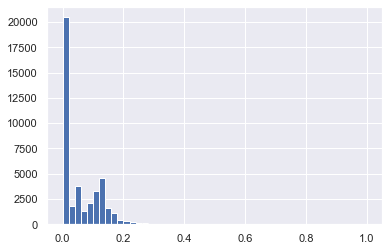

In [17]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)
# We plot a histogram of a variable with 50 bins.

(array([   3.,   16.,   15.,   44.,   16.,   13.,   68.,   26.,    7.,
          62.,   64.,   16.,   57.,   87.,   22.,   54.,   82.,   41.,
          47.,  120.,   81.,   68.,  119.,   85.,   86.,  104.,  114.,
         109.,  120.,  118.,  132.,  136.,  154.,  140.,  157.,  173.,
         145.,  183.,  194.,  171.,  199.,  205.,  207.,  206.,  232.,
         259.,  276.,  219.,  300.,  257.,  278.,  291.,  332.,  267.,
         356.,  357.,  375.,  357.,  382.,  406.,  403.,  421.,  430.,
         487.,  464.,  463.,  544.,  550.,  587.,  604.,  710.,  667.,
         606.,  781.,  789.,  760.,  849.,  828.,  888.,  916.,  897.,
        1053.,  906., 1184., 1006., 1035., 1302., 1013., 1326., 1038.,
        1360., 1254.,  926., 1364.,  771., 1266.,  556.,  915.,  330.,
         503.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

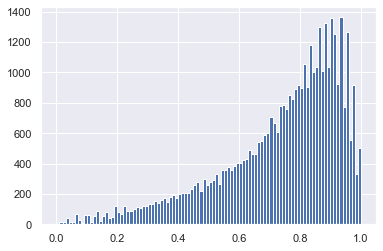

In [18]:
plt.hist(loan_data_defaults['CCF'], bins = 100)
# We plot a histogram of a variable with 100 bins.

In [19]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
# We create a new variable which is 0 if recovery rate is 0 and 1 otherwise.

# LGD Model

### Estimating the Model

### Linear Regression

In [19]:
lgd_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.

In [20]:
X=lgd_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF','loan_status'], axis = 1)
y=lgd_data['recovery_rate']

In [21]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [22]:
ss=StandardScaler()


#transform and create into a dataframe with column
X_train=ss.fit_transform(X_train)

# Transform.
X_test=ss.transform(X_test)



In [23]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

In [24]:
reg_lgd = LinearRegression()
ridge_model = RidgeCV(alphas=np.linspace(.1, 10, 100))
lasso_model = LassoCV(alphas=np.linspace(.1, 10, 100))


In [25]:
reg_lgd.fit(X_train,y_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

LinearRegression()

In [26]:
print("train r2:",reg_lgd.score(X_train,y_train))
print("validation r2:",reg_lgd.score(X_test,y_test))

train r2: 0.7043763715237354
validation r2: 0.6921575110713416


In [27]:
r_alpha=np.logspace(0,5,100)


# Cross-validate over our list of ridge alphas.

ridge_cv=RidgeCV(alphas=r_alpha,scoring='r2',cv=5)

# Fit model using best ridge alpha!
ridge_cv=ridge_model.fit(X_train,y_train)

In [28]:
ridge_cv.alpha_

1.5000000000000002

In [29]:
print("train r2:",ridge_cv.score(X_train,y_train))
print("validation r2:",ridge_cv.score(X_test,y_test))

train r2: 0.7043885228097944
validation r2: 0.6921361577091898


In [30]:
l_alphas=np.logspace(-3,1,100)
# Cross-validate over our list of Lasso alphas.cv is number of folds
lasso_cv=LassoCV(alphas=l_alphas,cv=5, max_iter=5000)
# Fit model using best ridge alpha!
lasso_cv.fit(X_train,y_train)

LassoCV(alphas=array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-0...
       1.17681195e+00, 1.29154967e+00, 1.41747416e+00, 1.55567614e+00,
       1.70735265e+00, 1.87381742e+00, 2.05651231e+00, 2.25701972e+00,
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01]),
        cv=5, max_iter=5000)

In [31]:
lasso_cv.alphas_

array([1.00000000e+01, 9.11162756e+00, 8.30217568e+00, 7.56463328e+00,
       6.89261210e+00, 6.28029144e+00, 5.72236766e+00, 5.21400829e+00,
       4.75081016e+00, 4.32876128e+00, 3.94420606e+00, 3.59381366e+00,
       3.27454916e+00, 2.98364724e+00, 2.71858824e+00, 2.47707636e+00,
       2.25701972e+00, 2.05651231e+00, 1.87381742e+00, 1.70735265e+00,
       1.55567614e+00, 1.41747416e+00, 1.29154967e+00, 1.17681195e+00,
       1.07226722e+00, 9.77009957e-01, 8.90215085e-01, 8.11130831e-01,
       7.39072203e-01, 6.73415066e-01, 6.13590727e-01, 5.59081018e-01,
       5.09413801e-01, 4.64158883e-01, 4.22924287e-01, 3.85352859e-01,
       3.51119173e-01, 3.19926714e-01, 2.91505306e-01, 2.65608778e-01,
       2.42012826e-01, 2.20513074e-01, 2.00923300e-01, 1.83073828e-01,
       1.66810054e-01, 1.51991108e-01, 1.38488637e-01, 1.26185688e-01,
       1.14975700e-01, 1.04761575e-01, 9.54548457e-02, 8.69749003e-02,
       7.92482898e-02, 7.22080902e-02, 6.57933225e-02, 5.99484250e-02,
      

In [32]:
print("train r2:",lasso_cv.score(X_train,y_train))
print("validation r2:",lasso_cv.score(X_test,y_test))

train r2: 0.7001466983018859
validation r2: 0.6915701409068301


## Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rf = RandomForestRegressor(random_state=42)

In [35]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.9842755549343425


{'max_depth': None, 'n_estimators': 200}

In [36]:
gs.score(X_train, y_train)

0.9981609110020594

In [37]:
gs.score(X_test, y_test)

0.988603271421588

## Building model- Voting Regressor with Adaboost and GBR

A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction. We will use three different regressors to predict the data: GradientBoostingRegressor, Adaboost). Then the above 3 regressors will be used for the VotingRegressor.



In [43]:
vote = VotingRegressor([
    
    ('ada', AdaBoostRegressor()),
    ('gb', GradientBoostingRegressor())
])

pipe_vote_params = {
    'ada__n_estimators': [50,75],
    'gb__n_estimators': [100,125],
    
}
gs = GridSearchCV(vote, param_grid=pipe_vote_params, cv=3,n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8339751029200793


{'ada__n_estimators': 50, 'gb__n_estimators': 125}

In [44]:
gs.score(X_train, y_train)

0.8455168678886684

In [45]:
gs.score(X_test, y_test)

0.8382447819801337

Out of the few models we have seen to model LGD, we can see that random forests with 200 estimators have the highest score of 0.99 for both the training set and testing set. This shows no overfit and the scores are significantly higher than that of linear regression and also adaboost/gradient boosting combinations. This model would be the best model to use to predict Loss given default(share of assets that are lost.aka proportion of the loan recovered after less recoviers  when a borrower defaults on a loan). Given more time, I would go on to explore more hypterparameters or to check the variance in scores in variation with the number of variables used in the model